In [5]:
import numpy as np
from scipy.integrate import solve_ivp, solve_bvp
from scipy.spatial.transform import Rotation as rot

import plotly.graph_objects as go

**Cosserat rod equations according to various sources:**

[Rucker & Webster 2011 (STATICS)](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=5957337) | [Gazzola et al 2018 (DYNAMICS)](https://mattia-lab.com/wp-content/uploads/2018/06/Gazzola_RSOS_2018.pdf)
- | -
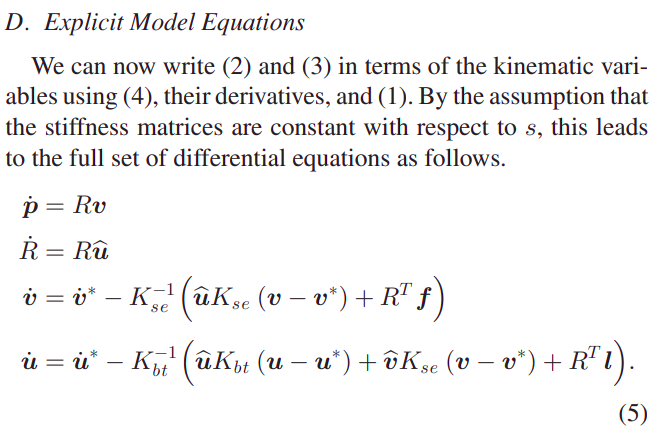 | 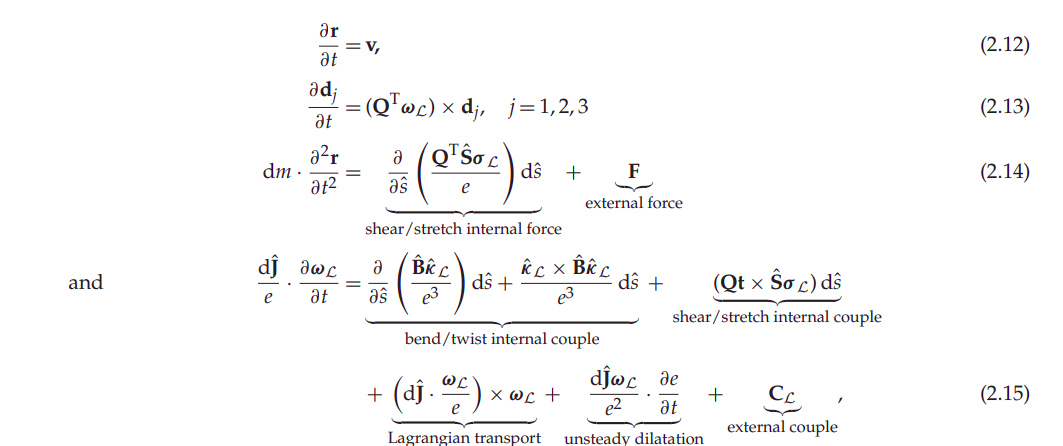


## Implementing Rucker & Webster
There are two conceptual ways of working with these equations. 
1. The first way is to roll everything into one ode solve: where $p, R, v, u$ is your state vectors. This is equivalent to the usual way of separating out a 2nd order ODE into a system of first order ones via $v := \dot{x}$ and the state vector thus as $X = [x, v]$. It's just now you have rotational components as well.
2. Since $\dot{p}$ and $\dot{R}$ are fully determined by $v$ and $u$, we can separate this out into two steps of integration: integrate $\dot{v}, \dot{u}$ numerically to obtain $v,u$, but then analytically integrate those via $\exp()$ to find the corresponding $p, R$. In theory, integrating $v$ and $u$ analytically via $\exp()$ should be as accurate as using a solver. The caveat is that the resolution is defined in the separate integration step.

In [2]:
# 3D kinematics/geometry helper functions
def mat_skew_sym_3(omega):
    # Create 3x3 skew-symmetric matrix given a 3-vector
    # Aka create the corresponding matrix to a cross-product
    # For converting an angular velocity vector to its matrix form
    # 
    # TODO: take a list of omega vectors?
    
    x, y, z = omega
    
    Omega = np.array([
        [0, -x, y],
        [x, 0, -z],
        [-y, z, 0]
    ])
    
    return Omega

def mat_skew_sym_4(omega):
    # Skew symmetric matrix for converting body frame angular velocities to the dq/dt quaternion rate of change
    # See https://math.stackexchange.com/questions/1797542/can-quaternions-be-used-to-represent-rotation-rate
    x, y, z = omega
    
    Omega = np.array([
        [0, -omega_x, -omega_y, -omega_z],
        [omega_x, 0, omega_z, -omega_y],
        [omega_y, -omega_z, 0, omega_x],
        [omega_z, omega_y, -omega_x, 0]
    ])

# Implement Rucker's equation
# y:= [p, R, v, u]
# 
# We store R not as its full rotation matrix but instead in quaternion form, giving a final expanded state:
# [x, y, z, q1, q2, q3, q4, v1, v2, v3, u1, u2, u3]
def rate_func_reduced(t, y, f, l, v_star, u_star, vdot_star, udot_star, K_se, K_bt):    
    v = y[0:3]
    R_q = y[3:7]
    v = y[7:10]
    u = y[10:13]
    
    # Apply conversions between matrix-vecor forms
    R = rot.from_quat(R_q).as_matrix() # We store the rotation as quaternion in state for compactness; now convert to mat
    u_hat = mat_skew_sym_3(u)
    v_hat = mat_skew_sym_3(v)
    
    ## System of ODEs from Rucker
    # Rate of change of position is the body-frame velocity rotated to world frame:
    pdot = R @ v
    
    # Rate of change of orinetation quaternion in wordl frame is the skew-symmetric form of angular vel
    # converted to an angular velocity in world frame by multiplying with current orientation quaternion
    R_qdot = 0.5 * mat_skew_sym_4(u) @ R_q
    
    # Beam bending equlibrium constituitive equations
    vdot = vdot_star - np.linalg.inv(K_se)(u_hat @ K_se @ (v - v_star) + R.T @ f)
    udot = udot_star - np.linalg.inv(K_bt)(u_hat @ K_bt @ (u - u_star) + K_se @ v_hat @ (v - v_star) + R.T @ l)
    
    dy = [pdot, R_qdot, vdot, udot]
    
    return dy

In [ ]:
## Tools for working with / visualizing rod kinematics:

## twist-field: twist at each point along the rod